In [610]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import matplotlib
from tqdm import tqdm
import json

# Define folder

In [30]:
folder_name = './creations/my_collec'

In [31]:
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Basic Info

# 1) Name of project

In [534]:
project_name = 'Test'

# 2) How many images do you want to generate in total?


In [578]:
image_count = 10

# Metadata

# 1) How should each image be named in the metadata?
## In the metadata, each image will be called NAME #ID.


In [579]:
basic_name = 'Rabbit'

# 2) What is the description of your collection?
## In the metadata, the description will be the same for each image

In [580]:
description = 'blablbla'

# 3) What is the name of this collection?


In [581]:
collection_name = 'Red Rabbits'

# MANUAL ACTION : DEFINE PROBA FILES
## in the collection output folder, include the probability distribution for each trait FOR EACH LAYER.
## Ex : the test collection has three layers - background, outfit and face. We have 3 probability files in the collection folder defined at the beginning

# Layer Ordering

In [582]:
class Layer:
    def __init__(self, name='Outfit', path_to_folder_of_images='files_test/Outfit/', image_type = 'png' , path_to_probas = './creations/my_collec/Outfit_probas.csv'):
        self.path_to_folder_of_images = path_to_folder_of_images
        
        self.image_names_with_file_type =  [file for file in os.listdir(self.path_to_folder_of_images) 
         if file.split('.')[-1] == image_type]
        
#         self.image_names_with_file_type = os.listdir(self.path_to_folder_of_images)
#         self.image_type = self.image_names_with_file_type[0].split('.')[-1]
        self.image_type = image_type

#         print(self.image_names_with_file_type)
        self.image_names = [f.split('.')[0] for f in self.image_names_with_file_type]       
        self.images = {}
        self.name=name
        for name in self.image_names:
            path_to_image = os.path.join(self.path_to_folder_of_images, name + '.' + self.image_type)
#             print('open {}'.format(path_to_image))
            self.images[name] = Image.open(path_to_image)
           
            
            
        self.probas = pd.read_csv(path_to_probas)
        self.path_to_probas = path_to_probas
        proba_sum = self.probas.proba.sum()
        assert proba_sum== 1, 'sum of probas for {} equals {} - needs to be equal to 1'.format(self.path_to_probas, proba_sum) 
        print('layer {} loaded successfully'.format(self.name))

In [583]:
Background_layer = Layer(name = 'Background', path_to_folder_of_images= 'files_test/Background/', image_type = 'png' , path_to_probas='./creations/my_collec/Background_probas.csv')
Outfit_layer = Layer(name = 'Outfit', path_to_folder_of_images= 'files_test/Outfit/', image_type = 'png', path_to_probas='./creations/my_collec/Outfit_probas.csv')
Face_layer = Layer(name = 'Face', path_to_folder_of_images= 'files_test/Face/', image_type = 'png' , path_to_probas='./creations/my_collec/Face_probas.csv')


layer Background loaded successfully
layer Outfit loaded successfully
layer Face loaded successfully


In [600]:
class Collection:
    def __init__(self, list_of_layers, image_count = image_count, project_name=project_name, basic_name=basic_name,collection_name=collection_name):
        self.list_of_layers = list_of_layers
        self.image_count=image_count
        self.project_name=project_name
        self.image_count=image_count
        self.basic_name=basic_name
        self.description=description
        self.collection_name=collection_name
    
    def generate(self):
        selected_traits = {}
        for l in self.list_of_layers:
            random_selection = np.random.choice(l.probas.trait.values,self.image_count, p=l.probas.proba.values)
            selected_traits[l.name] = random_selection 
        
        
        output = []
        for i in tqdm(range(self.image_count)):
            metadata = {'project_name' : self.project_name,
                       'image_count':self.image_count,
                       'ntf_name':self.basic_name + '_{}'.format(i),
                       'description':self.description,
                       'collection_name':self.collection_name,
                       'attributes':{}}
            temp_list_of_images = []
            for l in self.list_of_layers:
                local_trait = selected_traits[l.name][i]
                metadata['attributes'][l.name]=local_trait
                local_image = l.images[local_trait]
                temp_list_of_images += [local_image]
                
            combined_image = self.combine_images(temp_list_of_images)
            output += [[combined_image, metadata]]
        return(output)
                
                
    def combine_images(self, list_of_images):
        assert len(list_of_images)>0, 'no images given'
        list_of_arrays = [np.asarray(img).astype('float') for img in list_of_images]


        total_number_of_images = len(list_of_images)
        
        #respect the order of the layers
        output_array = list_of_arrays[0]
        for new_array in list_of_arrays[1:]:
            mask = new_array>0
            output_array = output_array*(1-mask) + mask*new_array
        
        output_image = Image.fromarray(output_array.astype('uint8'))
        return(output_image)
                
            
        

In [601]:
list_of_layers = [Background_layer,Outfit_layer,Face_layer]

In [602]:
Collec = Collection(list_of_layers)

In [603]:
c = Collec.generate()

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2769.98it/s]


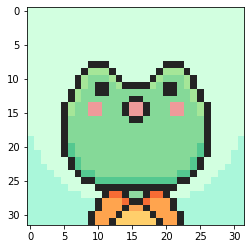

In [604]:
plt.imshow(c[2][0])

In [605]:
c[2][1]

{'project_name': 'Test',
 'image_count': 10,
 'ntf_name': 'Rabbit_2',
 'description': 'blablbla',
 'collection_name': 'Red Rabbits',
 'attributes': {'Background': 'Green Background',
  'Outfit': 'Cape Shirt',
  'Face': 'Surprised'}}

# save collection

In [606]:
image_folder = os.path.join(folder_name, 'images_generated')
metadata_folder = os.path.join(folder_name, 'metadata_generated')

In [607]:
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
if not os.path.exists(metadata_folder):
    os.makedirs(metadata_folder)

In [608]:
for image, metadata in tqdm(c):
    image_path = os.path.join(image_folder, metadata['ntf_name']+".png")
    image.save(image_path, 'png')
    
    metadata_path = os.path.join(metadata_folder, metadata['ntf_name']+".json")
    with open(metadata_path,'w') as fp:
        json.dump(metadata, fp)


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 809.12it/s]
